<a href="https://colab.research.google.com/github/vaylerie/starfish-classification/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications import MobileNet
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.backend import clear_session

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# Set directory paths
image_dir = '/content/drive/MyDrive/ProjectSiscerBintangLaut/Dataset'

# Load data into DataFrame
filename = []
label = []
# Iterate through each directory in image_dir
for dir_name in os.listdir(image_dir):
    # Iterate through each file in the directory
    for file in os.listdir(os.path.join(image_dir, dir_name)):
        # Append file path and label to lists
        filename.append(os.path.join(dir_name, file))
        label.append(dir_name)

In [17]:
# Check total data
print(len(filename))

200


In [18]:
# Create a DataFrame to hold the file paths and labels
data = {"filename": filename, "label": label}
df = pd.DataFrame(data)
print(df)

                          filename                 label
0       Linckia Laevigata/LL34.png     Linckia Laevigata
1       Linckia Laevigata/LL46.png     Linckia Laevigata
2       Linckia Laevigata/LL31.png     Linckia Laevigata
3       Linckia Laevigata/LL38.png     Linckia Laevigata
4       Linckia Laevigata/LL21.png     Linckia Laevigata
..                             ...                   ...
195  Protoreaster Nodosus/PN16.png  Protoreaster Nodosus
196   Protoreaster Nodosus/PN4.png  Protoreaster Nodosus
197   Protoreaster Nodosus/PN3.png  Protoreaster Nodosus
198  Protoreaster Nodosus/PN17.png  Protoreaster Nodosus
199  Protoreaster Nodosus/PN12.png  Protoreaster Nodosus

[200 rows x 2 columns]


In [19]:
# Shuffle the DataFrame
df_shuffled = df.sample(frac=1).reset_index(drop=True)
print(df_shuffled.head)

<bound method NDFrame.head of                           filename                 label
0        Luidia Foliolata/LF10.png      Luidia Foliolata
1       Linckia Laevigata/LL29.png     Linckia Laevigata
2    Protoreaster Nodosus/PN31.png  Protoreaster Nodosus
3     Protoreaster Nodosus/PN8.png  Protoreaster Nodosus
4    Protoreaster Nodosus/PN21.png  Protoreaster Nodosus
..                             ...                   ...
195   Culcita Novaguineae/CN29.png   Culcita Novaguineae
196     Linckia Laevigata/LL24.png     Linckia Laevigata
197  Protoreaster Nodosus/PN35.png  Protoreaster Nodosus
198      Linckia Laevigata/LL6.png     Linckia Laevigata
199   Culcita Novaguineae/CN10.png   Culcita Novaguineae

[200 rows x 2 columns]>


In [20]:
# Check the total data of each class
print(df['label'].value_counts())

label
Linckia Laevigata       50
Culcita Novaguineae     50
Luidia Foliolata        50
Protoreaster Nodosus    50
Name: count, dtype: int64


In [40]:
# Split data into training, validation, and testing sets (90% training, 10% testing)
train_df, test_df = train_test_split(df_shuffled, test_size=0.1, stratify=df_shuffled['label'], random_state=42)

print(f"Training set: {len(train_df)}")
print(f"Testing set: {len(test_df)}")
print("----------------------------------")
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

Training set: 180
Testing set: 20
----------------------------------
label
Protoreaster Nodosus    45
Culcita Novaguineae     45
Linckia Laevigata       45
Luidia Foliolata        45
Name: count, dtype: int64
label
Culcita Novaguineae     5
Protoreaster Nodosus    5
Linckia Laevigata       5
Luidia Foliolata        5
Name: count, dtype: int64


In [41]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and testing data
test_datagen = ImageDataGenerator(rescale=1./255)

In [42]:
# Prepare data generators
train_data_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=image_dir,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=8,
    class_mode="categorical",
    shuffle=True
)

val_data_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=image_dir,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=8,
    class_mode="categorical",
    shuffle=False
)

Found 180 validated image filenames belonging to 4 classes.
Found 20 validated image filenames belonging to 4 classes.


In [43]:
# Define the model
def build_model():
    # Load pre-trained MobileNet model without top layer
    pretrained_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    # Freeze all layers in the pre-trained model
    for layer in pretrained_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    x = GlobalAveragePooling2D()(pretrained_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(4, activation='softmax')(x)  # Assuming there are 4 classes
    model = Model(pretrained_model.input, output)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [44]:
# Cross-validation and training
kf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

# Lists to store evaluation metrics
VALIDATION_ACCURACY = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_F1SCORE = []

LOSS = []
ACCURACY = []

VAL_LOSS = []
VAL_ACCURACY = []

# Containers for per-fold scores
acc_per_fold = []
loss_per_fold = []

# Variable for fold iteration
fold_var = 1
Y = train_df[['label']]

In [45]:
save_dir = '/content/drive/MyDrive/ProjectSiscerBintangLaut/Hasil/MobileNet'

In [ ]:
# Perform k-fold cross-validation
for train_index, val_index in kf.split(np.zeros(len(Y)), Y):
    training_data = train_df.iloc[train_index]
    validation_data = train_df.iloc[val_index]

    # Create data generators for training and validation
    train_data_generator = train_datagen.flow_from_dataframe(
        training_data,
        directory=image_dir,
        x_col="filename",
        y_col="label",
        target_size=(224, 224),
        batch_size=8,
        class_mode="categorical",
        shuffle=True
    )

    valid_data_generator = test_datagen.flow_from_dataframe(
        validation_data,
        directory=image_dir,
        x_col="filename",
        y_col="label",
        target_size=(224, 224),
        batch_size=8,
        class_mode="categorical",
        shuffle=False
    )

    print('\n')
    print(f'Training for fold {fold_var} ...')

    # Build and train the model
    model = build_model()
    hist = model.fit(
        train_data_generator,
        validation_data=valid_data_generator,
        epochs=10,
        steps_per_epoch=training_data.shape[0] // 8
    )

    # Save the model
    model.save(os.path.join(save_dir, f"model_fold_{fold_var}.h5"))
    print(f"Model for fold {fold_var} saved to {save_dir}.")
    print('\n')

    # Evaluate the model on validation data
    results = model.evaluate(valid_data_generator)
    print(f'Score for fold {fold_var}: {model.metrics_names[0]} of {results[0]}; {model.metrics_names[1]} of {results[1] * 100}%')

    # Predict labels for validation data
    y_predict = model.predict(valid_data_generator)
    y = np.asarray(valid_data_generator.labels)
    y_predict_labels = np.argmax(y_predict, axis=1)

    # Calculate evaluation metrics
    acc = accuracy_score(y_predict_labels, y)
    prec = precision_score(y_predict_labels, y, average='weighted')
    rec = recall_score(y_predict_labels, y, average='weighted')
    f1score = f1_score(y_predict_labels, y, average='weighted')

    print("\n")
    print("Cross Validation : ", fold_var)
    print("Accuracy : ", results[1])
    print("Precision : ", prec)
    print("Recall : ", rec)
    print("F1Score : ", f1score)
    print("\n")

    # Plot training history
    plt.plot(hist.history['loss'], label='Loss')
    plt.plot(hist.history['accuracy'], label='Accuracy')
    plt.title(f'Model Accuracy and Loss Fold {fold_var}')
    plt.ylabel('value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.savefig(os.path.join(save_dir, f'plot_fold_{fold_var}.png'))
    plt.show()
    print(f"Plot for fold {fold_var} saved to {save_dir}.")
    print('\n')

    # Append metrics to lists
    VALIDATION_ACCURACY.append(results[1])
    VALIDATION_PRECISION.append(prec)
    VALIDATION_RECALL.append(rec)
    VALIDATION_F1SCORE.append(f1score)

    LOSS.append(hist.history['loss'])
    ACCURACY.append(hist.history['accuracy'])

    VAL_LOSS.append(hist.history['val_loss'])
    VAL_ACCURACY.append(hist.history['val_accuracy'])

    acc_per_fold.append(results[1] * 100)
    loss_per_fold.append(results[0])

    # Display confusion matrix for validation set
    print(f"\nConfusion Matrix for Fold {fold_var}:")
    print(confusion_matrix(y, y_predict_labels))
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y, y_predict_labels), annot=True, fmt=".0f")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Fold {fold_var}")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'confusion_matrix_fold_{fold_var}.png'))
    plt.show()
    print(f"Confusion Matrix for fold {fold_var} saved to {save_dir}.")
    print('\n')

    fold_var += 1

In [69]:
print(VALIDATION_ACCURACY)
print(VALIDATION_PRECISION)
print(VALIDATION_RECALL)
print(VALIDATION_F1SCORE)

[1.0, 0.9722222089767456, 1.0, 0.9444444179534912, 1.0]
[1.0, 0.9753086419753088, 1.0, 0.95679012345679, 1.0]
[1.0, 0.9722222222222222, 1.0, 0.9444444444444444, 1.0]
[1.0, 0.9723082215342278, 1.0, 0.946454678362573, 1.0]


In [49]:
# Provide average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} ')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0021481106523424387 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.048887114971876144 - Accuracy: 97.22222089767456%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0020666467025876045 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.13278622925281525 - Accuracy: 94.44444179534912%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.007561595179140568 - Accuracy: 100.0%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 98.33333253860474 
> Loss: 0.0386899393517524
------------------------------------------------------------------------


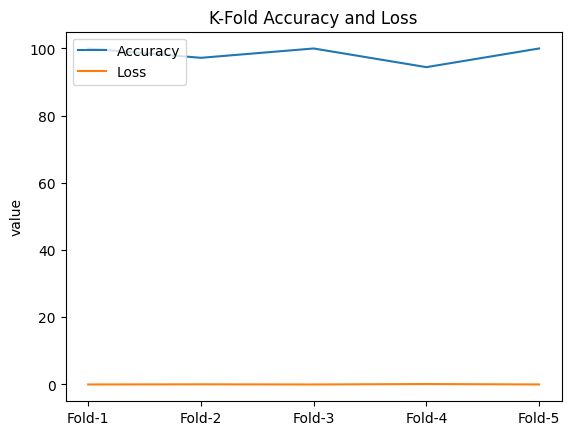

K-Fold Accuracy and Loss Plot saved to /content/drive/MyDrive/ProjectSiscerBintangLaut/Hasil/MobileNet.




In [50]:
# Plotting K-Fold Accuracy and Loss
plt.plot(acc_per_fold, label='Accuracy')
plt.plot(loss_per_fold, label='Loss')
plt.title('K-Fold Accuracy and Loss')
plt.ylabel('value')
x = ["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"]

default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)
plt.legend(loc="upper left")
plt.savefig(os.path.join(save_dir, f'K_fold_accuracy_loss_plot.png'))
plt.show()
print(f"K-Fold Accuracy and Loss Plot saved to {save_dir}.")
print('\n')

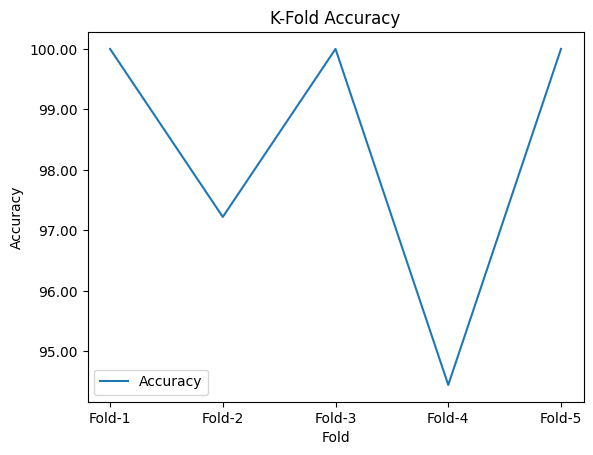

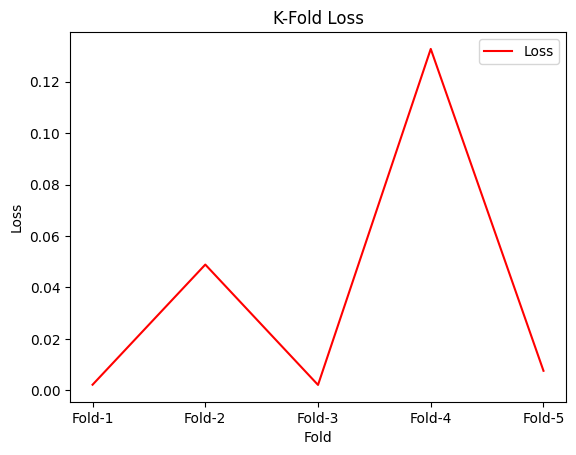

In [71]:
# Plotting Accuracy for each fold
plt.plot(acc_per_fold, label='Accuracy')
plt.title('K-Fold Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.xticks(default_x_ticks, x)
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.legend()
plt.savefig(os.path.join(save_dir, 'kfold_accuracy_plot.png'))
plt.show()

# Plotting Loss for each fold
plt.plot(loss_per_fold, label='Loss', color='red')
plt.title('K-Fold Loss')
plt.ylabel('Loss')
plt.xlabel('Fold')
plt.xticks(default_x_ticks, x)
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.legend()
plt.savefig(os.path.join(save_dir, 'kfold_loss_plot.png'))
plt.show()

In [51]:
# Evaluate on the test set
model = build_model()  # Rebuild the model for final evaluation
model.fit(train_data_generator, epochs=10, steps_per_epoch=train_df.shape[0] // 8)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
18/22 [=======================>......] - ETA: 1s - loss: 0.9630 - accuracy: 0.6736

22/22 [==============================] - 10s 309ms/step - loss: 0.9630 - accuracy: 0.6736


In [61]:
# Evaluate model on test data
test_results = model.evaluate(val_data_generator)
print(f'Test Loss: {test_results[0] * 100}%')
print(f'Test Accuracy: {test_results[1] * 100}%')

3/3 [==============================] - 2s 358ms/step - loss: 0.0974 - accuracy: 1.0000
Test Loss: 9.740599989891052%
Test Accuracy: 100.0%


In [64]:
# Predict labels for test data
y_test_predict = model.predict(val_data_generator)
y_test = np.asarray(val_data_generator.labels)
y_test_predict_labels = np.argmax(y_test_predict, axis=1)

3/3 [==============================] - 2s 549ms/step


In [70]:
# Display confusion matrix for test set
print("\nConfusion Matrix on Test Set")
print(confusion_matrix(y_test, y_test_predict_labels))


Confusion Matrix on Test Set
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


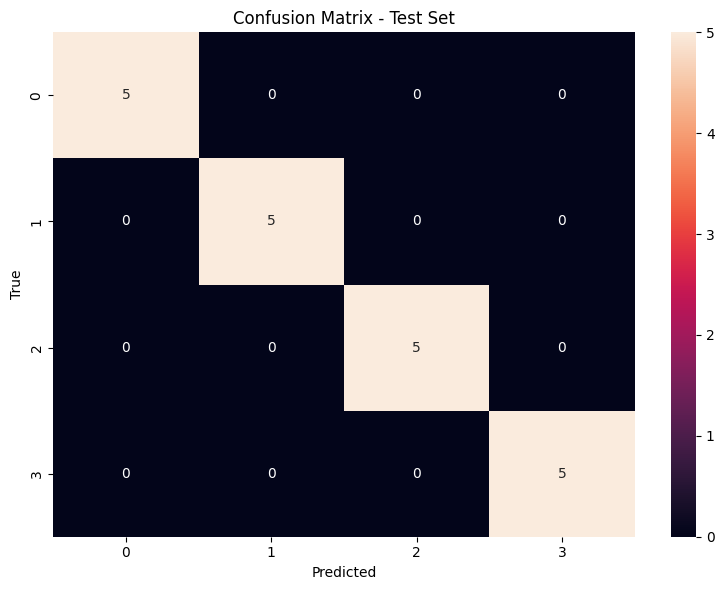

In [66]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_predict_labels), annot=True, fmt=".0f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'confusion_matrix_test.png'))
plt.show()

In [67]:
# Display classification report for test set
target_names = ['Culcita novaguineae', 'Linckia laevigatai', 'Luidia foliolata', 'Protoreaster nodosus']
print(classification_report(y_test, y_test_predict_labels, target_names=target_names))

                      precision    recall  f1-score   support

 Culcita novaguineae       1.00      1.00      1.00         5
  Linckia laevigatai       1.00      1.00      1.00         5
    Luidia foliolata       1.00      1.00      1.00         5
Protoreaster nodosus       1.00      1.00      1.00         5

            accuracy                           1.00        20
           macro avg       1.00      1.00      1.00        20
        weighted avg       1.00      1.00      1.00        20

